# Loading the tfrecords


In [1]:
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import RandomRotation
import matplotlib.pyplot as plt

In [2]:
def parse_tfrecord(example_proto):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    label = tf.strings.to_number(example["label"], out_type=tf.int64)  # Convert label to int64
    return image, label

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train_tfrecord="/content/drive/MyDrive/nsl2/images/tfrecords/train.tfrecord"
val_tfrecord="/content/drive/MyDrive/nsl2/images/tfrecords/val.tfrecord"
test_tfrecord="/content/drive/MyDrive/nsl2/images/tfrecords/test.tfrecord"
num_classes = 36
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

In [ ]:
# counting the number of images
len_train = tf.data.TFRecordDataset(train_tfrecord)
len_test = tf.data.TFRecordDataset(val_tfrecord)
count_1 = sum(1 for _ in len_train)
count_2 = sum(1 for _ in len_test)
print("Number of images in the TFRecord:", count_1, count_2)

Number of images in the TFRecord: 37862 8113


In [5]:
# Sample 10 random images from each class
def sample_images(dataset, num_classes, num_samples=10):
    class_images = {i: [] for i in range(num_classes)}

    # Collect images for each class
    for image, label in dataset:
        label = int(label.numpy())
        if len(class_images[label]) < num_samples:
            class_images[label].append(image)
        if all(len(images) == num_samples for images in class_images.values()):
            break  # Stop if we have enough samples for all classes

    return class_images

def visualize_samples(class_images, num_samples=10):
    for label, images in class_images.items():
        print(f"Class {label}:")
        fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
        for i, img in enumerate(images):
            # Convert TensorFlow Tensor to NumPy array and normalize pixel values
            img_array = img.numpy()
            if img_array.dtype == float:  # Normalize if in range [0, 1]
                img_array = (img_array * 255).astype("uint8")
            axes[i].imshow(img_array)
            axes[i].axis("off")
        plt.show()

In [6]:
def load_dataset(tfrecord_file, augment=False, include_tags=False): #including tags only for visualization purposes
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
    parsed_dataset = raw_dataset.map(parse_tfrecord)

    if augment:
        if include_tags:
            parsed_dataset = parsed_dataset.map(apply_augmentations_with_tags, num_parallel_calls=tf.data.AUTOTUNE)
        else:
            parsed_dataset = parsed_dataset.map(apply_augmentations, num_parallel_calls=tf.data.AUTOTUNE)

    return parsed_dataset

In [ ]:
NUM_SAMPLES = 5
dataset = load_dataset(train_tfrecord)
class_images = sample_images(dataset, num_classes, NUM_SAMPLES)
visualize_samples(class_images, NUM_SAMPLES)
#output is too large, so clearing it

In [8]:
tf.random.set_seed(42)
random_rotation = RandomRotation(factor=(-30 / 360, 30 / 360), fill_mode='reflect')

def apply_augmentations(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # Random horizontal flip (30% probability)
    if tf.random.uniform([], seed=42) < 0.35:
        image = tf.image.flip_left_right(image)
    # Random contrast adjustment (5% probability)
    if tf.random.uniform([], seed=42) < 0.05:
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # Random rotation (-30 to 30 degrees, 20% probability)
    if tf.random.uniform([], seed =42) < 0.25:
        image = random_rotation(image)
    return image, label

In [ ]:
# With augmentations for training
train_dataset = load_dataset(train_tfrecord, augment=True)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE).repeat()

# Without augmentations for validation or test
val_dataset = load_dataset(val_tfrecord, augment=False)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = load_dataset(test_tfrecord, augment=False)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
# we wont use test dataset here though

# Visualizing augmentations

In [11]:
def apply_augmentations_with_tags(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    tag = "original"
    # Random horizontal flip (30% probability)
    if tf.random.uniform([], seed=42) < 0.35:
        image = tf.image.flip_left_right(image)
        tag="flipped"
    # Random contrast adjustment (5% probability)
    if tf.random.uniform([], seed=42) < 0.05:
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        tag="rotated"
    # Random rotation (-30 to 30 degrees, 20% probability)
    if tf.random.uniform([], seed =42) < 0.25:
        image = random_rotation(image)
    return image, label, tag


In [12]:
def visualize_specific_augmentation(dataset, augmentation_tag, num_images):
    count = 0
    plt.figure(figsize=(12, 12))

    for image, label, tag in dataset.take(num_images * 2):  # Take extra to account for filtering
        if tag.numpy().decode("utf-8") == augmentation_tag:
            plt.subplot(5, 5, count + 1)
            plt.imshow(image.numpy())
            plt.title(f"Label: {label.numpy()}, Tag: {tag.numpy().decode('utf-8')}")
            plt.axis("off")
            count += 1
            if count >= num_images:
                break
    plt.tight_layout()
    plt.show()

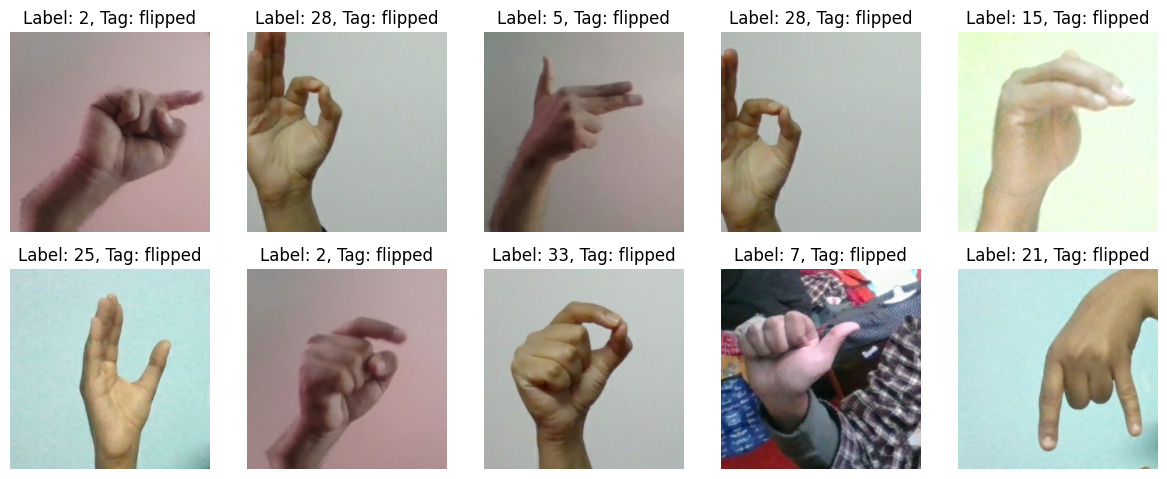

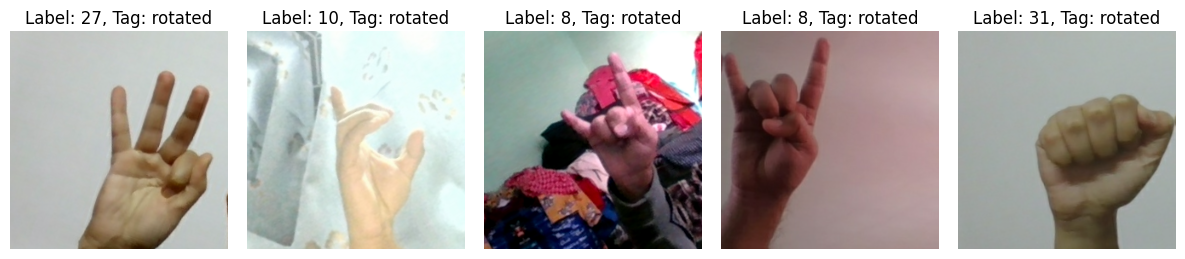

In [14]:
debug_dataset = load_dataset(train_tfrecord, augment=True, include_tags=True).batch(1)
visualize_specific_augmentation(debug_dataset.unbatch(), augmentation_tag="flipped", num_images=20)
visualize_specific_augmentation(debug_dataset.unbatch(), augmentation_tag="rotated", num_images=20)

# Training

In [16]:
from tensorflow.keras import layers, applications, Model, Input
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## using MobileNetV2

In [34]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet', alpha = 0.5)
base_model.trainable = False

/tmp/ipython-input-34-1047083484.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet', alpha = 0.5)


3201480/3201480 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [37]:
model = tf.keras.Sequential([
base_model,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(128, activation='relu'), #128 should be enough
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [38]:
model.summary(show_trainable=True)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ mobilenetv2_0.50_224        │ (None, 8, 8, 1280)    │    706,224 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_3  │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_6 (Dense)             │ (None, 128)           │    163,968 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_3 (Dropout)         │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_7 (Dense)             │ (None, 36)            │      4,644 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 874,836 (3.34 MB)

 Trainable params: 168,612 (658.64 KB)

 Non-trainable params: 706,224 (2.69 MB)

In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [40]:
total_history = []

In [41]:
history = model.fit(train_dataset, steps_per_epoch=1184, epochs=3, validation_data=val_dataset)
total_history.append(history)

Epoch 1/3
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 133s 104ms/step - accuracy: 0.7914 - loss: 0.7111 - val_accuracy: 0.9516 - val_loss: 0.1436
Epoch 2/3
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 108s 91ms/step - accuracy: 0.9205 - loss: 0.2810 - val_accuracy: 0.9699 - val_loss: 0.1740
Epoch 3/3
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 142s 120ms/step - accuracy: 0.9320 - loss: 0.2685 - val_accuracy: 0.9845 - val_loss: 0.0549


In [42]:
print(len(base_model.layers))

154


In [43]:
for layer in base_model.layers[60:]:
  layer.trainable = True

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [45]:
history = model.fit(train_dataset, steps_per_epoch=1184, epochs=3, validation_data=val_dataset)
total_history.append(history)

Epoch 1/3
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 229s 121ms/step - accuracy: 0.8114 - loss: 0.9102 - val_accuracy: 0.7514 - val_loss: 1.7008
Epoch 2/3
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 138s 116ms/step - accuracy: 0.9667 - loss: 0.1363 - val_accuracy: 0.9313 - val_loss: 0.3205
Epoch 3/3
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 145s 123ms/step - accuracy: 0.9744 - loss: 0.1049 - val_accuracy: 0.9516 - val_loss: 0.5281


In [47]:
base_model.trainable=True

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [50]:
history = model.fit(train_dataset, steps_per_epoch=1184, epochs=4, validation_data=val_dataset)
total_history.append(history)

Epoch 1/4
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 249s 156ms/step - accuracy: 0.9803 - loss: 0.0769 - val_accuracy: 0.9990 - val_loss: 0.0054
Epoch 2/4
   2/1184 ━━━━━━━━━━━━━━━━━━━━ 1:34 80ms/step - accuracy: 0.9766 - loss: 0.0417

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 199s 168ms/step - accuracy: 0.9935 - loss: 0.0222 - val_accuracy: 0.9985 - val_loss: 0.0061
Epoch 3/4
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 201s 170ms/step - accuracy: 0.9941 - loss: 0.0208 - val_accuracy: 0.9988 - val_loss: 0.0036
Epoch 4/4
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 159s 134ms/step - accuracy: 0.9947 - loss: 0.0167 - val_accuracy: 0.9993 - val_loss: 0.0045


# Evaluation

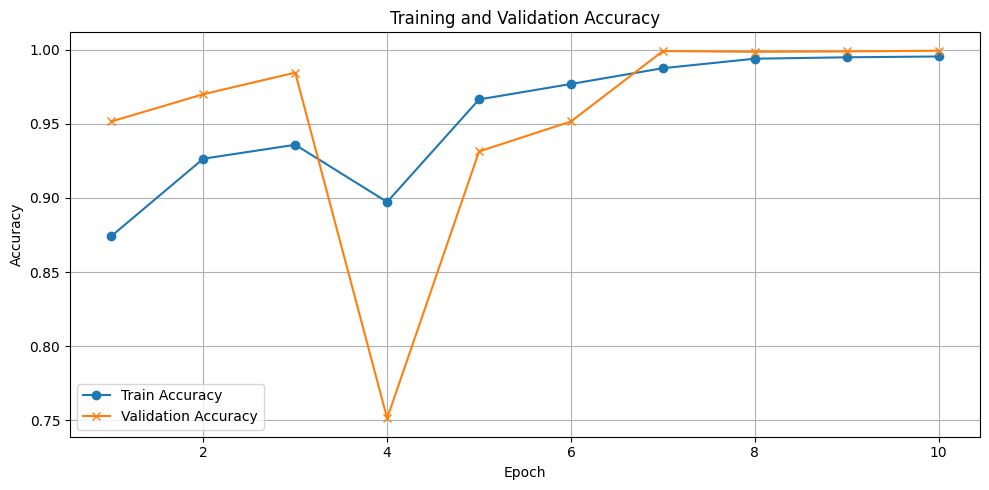

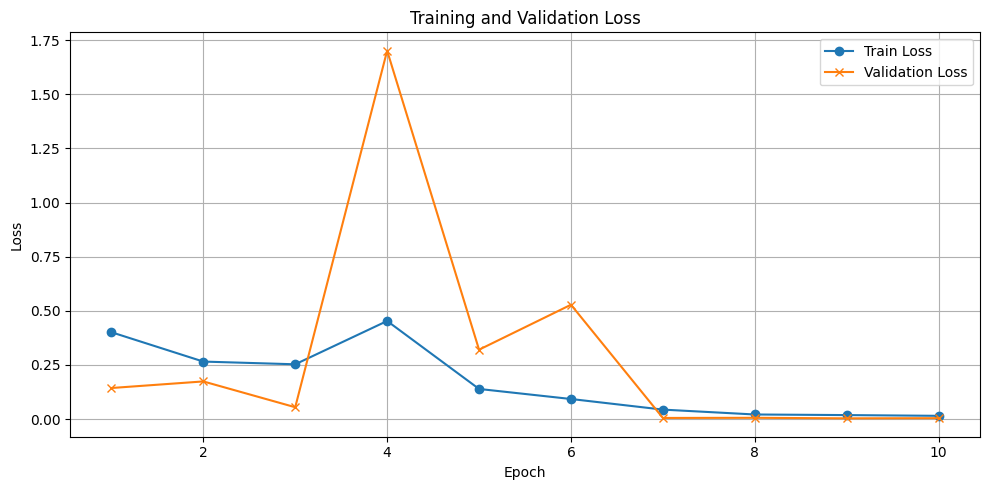

In [52]:
# Initialize lists
train_acc = []
val_acc = []
train_loss = []
val_loss = []
epochs = []

epoch_counter = 0

# Loop through each training history
for history in total_history:
    acc = history.history['accuracy']
    val = history.history['val_accuracy']
    loss = history.history['loss']
    val_l = history.history['val_loss']
    n = len(acc)

    train_acc.extend(acc)
    val_acc.extend(val)
    train_loss.extend(loss)
    val_loss.extend(val_l)
    epochs.extend(range(epoch_counter + 1, epoch_counter + n + 1))

    epoch_counter += n

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


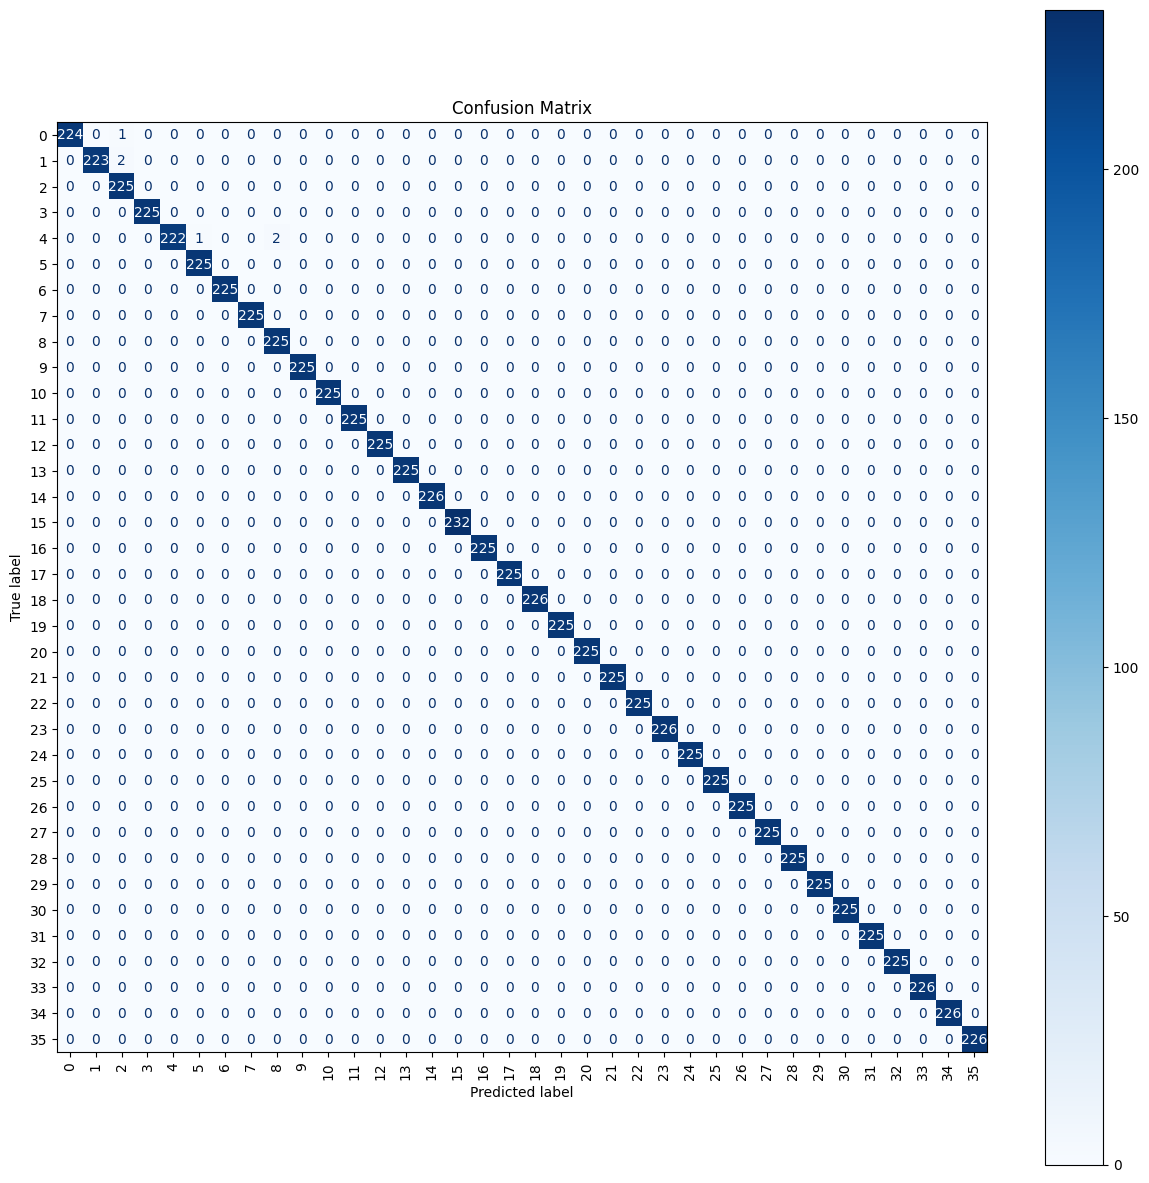

In [53]:
true_labels = []
predicted_labels = []

for images, labels in val_dataset:  # Iterate through the test dataset
    predictions = model.predict(images, verbose = 0)  # Get predictions
    predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

    true_labels.extend(labels.numpy())  # Collect true labels
    predicted_labels.extend(predicted_classes)  # Collect predicted labels

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Set the figure size
plt.figure(figsize=(15, 15))  # Adjust the figsize as needed (width, height in inches)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)  # Adjust labels if needed
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=True)  # Use plt.gca() to ensure it plots on the current figure

plt.title("Confusion Matrix")
plt.xticks(rotation=90)  # Rotate x-axis labels if they overlap
plt.show()

In [54]:
model_dir="/content/drive/MyDrive/nsl2/images/models/mbnet2.keras"
model.save(model_dir)

# Inference

In [55]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [56]:
model_dir="/content/drive/MyDrive/nsl2/images/models/mbnet2.keras"
model = tf.keras.models.load_model(model_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


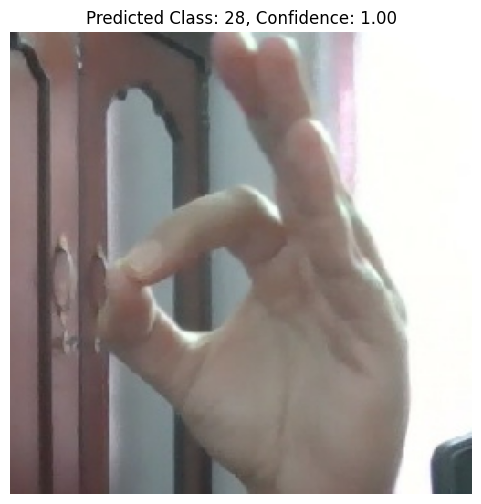

In [57]:
image_path = "/content/drive/MyDrive/Temptemp/received_878922874317822.jpeg"
image_size = (256, 256)

image = load_img(image_path, target_size=image_size)
image_array = img_to_array(image)
image_array = image_array / 255.0
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension -> (1, H, W, C)

# Run inference
predictions = model.predict(image_array)
predicted_class = np.argmax(predictions, axis=1)
confidence = np.max(predictions)

# Visualize the result
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class[0]}, Confidence: {confidence:.2f}")
plt.axis("off")
plt.show()